# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

Set the vm_ variable according to your need.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

vm_ = False
if vm_:
    env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
else:
    env = UnityEnvironment(file_name="data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# Useful Functions

def act(env, actions, brain_name="TennisBrain") -> tuple:
    """Sends actions to the environment env and observes the results.
    Returns a tuple of rewards, next_states, dones (One per agent)"""
    action_result = env.step(actions)[brain_name] # Act on the environment and observe the result
    return (action_result.rewards,
            action_result.vector_observations, # next states
            action_result.local_done) # True if the episode ended
    
def reset(env, training=True, brain_name="TennisBrain") -> np.ndarray:
    """Resetting the unity environment"""
    return env.reset(train_mode=training)[brain_name].vector_observations

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Ready for training

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
# Invite our agent & import torch
from ddpg_agent import Agent
from ddpg_buffer import ReplayBuffer
import torch
import random

# Training params
random_seed = random.randint(0, 1e6)

# Define Training variable
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 300        # minibatch size
# print(random_seed)

In [6]:
def train(agents, buffer, env, num_episodes, log_freq, max_t=20000, profiling=False, profiler=None): 
    """Train agents to solve the environemnt env.
    
    Params
    ======
    agents (List of ddpg_agent.Agent): The MADDPG agents to be trained
    buffer (buffer.ReplayBuffer): The experience replay buffer shared by all agents
    env: The unity environment
    num_episodes (int): The maximum number of episodes that the training will run
    log_freq (int): Print progress report each log_freq episodes
    max_t (int): The maximum number of time steps per episode
    profiling (bool): Whether to profile execution time
    profiler (cProfile.Profile): The profiler to be used during profiling
    """
    # Preparations
    score_hist = []
    if profiling: 
        profile.enable()
    
    # Train
    for i in range(num_episodes):
        states = reset(env)
        scores = np.zeros(num_agents)
        if i > 0:
            for agent in agents:
                # Decrease noise amplitude
                agent.ounoise.decay_step()
            
        for j in range(max_t):         
            
            # Each agent decides its action based on its own observation
            assert len(states) == len(agents), 'size mismatch'
            actions = np.vstack([agent.decide(np.expand_dims(state, 0)) for agent, state in zip(agents, states)])
                
            # Send the actions to the environment
            rewards, next_states, dones = act(env, actions)     
            scores += rewards
            
            # Save to buffer
            buffer.add(states, actions, rewards, next_states, dones)
            
            # Update in mini-batches
            if len(buffer) >= BATCH_SIZE:
                for agent_number, agent in enumerate(agents):
                    # Sample experiences *separately* for each agent
                    experiences = buffer.sample(BATCH_SIZE) # Returns (states, actions, rewards, next_states, dones)
            
                    # To update each agent, besides the info in experiences, we need...
                    # ... The actions that all target actors take observing states s'
                    assert len(experiences[3]) == len(agents), 'size mismatch' # experiences[3]: next_states
                    next_actions = [a.decide(s, use_target=True, as_tensor=True, autograd=False, add_noise=False)
                                    for a, s in zip(agents, experiences[3])]
            
                    # ... The actions that all local actors take observing states s
                    assert len(experiences[0]) == len(agents), 'size mismatch' # experiences[0]: states
                    current_actions = [a.decide(s, use_target=False, as_tensor=True, autograd=True, add_noise=False)
                                       for a, s in zip(agents, experiences[0])]
                    
                    # Finally apply the update
                    agent.learn(experiences, next_actions, current_actions, agent_number)

            # Step
            states = next_states # roll over states to next time step
            if np.any(dones): # exit loop if episode finished
                break 
                
        # Logging
        score_hist.append(max(scores))
        if (i % log_freq == 0) and (i > 0):
            print(f'Avg. score episodes {i-log_freq}-{i}: {np.mean(score_hist[-log_freq:])}')
        
        if np.mean(score_hist[-100:]) >= .5:
            print(f'Solved in {i} steps!')
            break

    if profiling: 
        profile.disable()
        
    return np.array(score_hist)

Train now!

In [7]:

buffer = ReplayBuffer(BUFFER_SIZE, num_agents, True)
agents = [Agent(state_size=state_size, 
                action_size=action_size, 
                num_agents=num_agents, 
                noise_theta  = 1,
                noise_sigma = .35,
                noise_decay_rate = .999,
                random_seed=random_seed) for agent in ('A', 'B')]

score_hist = train(agents, buffer, env, num_episodes=8000, log_freq=100)

Avg. score episodes 0-100: 0.0030000000447034836
Avg. score episodes 100-200: 0.0
Avg. score episodes 200-300: 0.0
Avg. score episodes 300-400: 0.004000000059604645
Avg. score episodes 400-500: 0.0010000000149011613
Avg. score episodes 500-600: 0.0
Avg. score episodes 600-700: 0.01160000018775463
Avg. score episodes 700-800: 0.005400000102818012
Avg. score episodes 800-900: 0.010400000177323818
Avg. score episodes 900-1000: 0.013800000213086605
Avg. score episodes 1000-1100: 0.016900000255554916
Avg. score episodes 1100-1200: 0.019000000339001417
Avg. score episodes 1200-1300: 0.05570000087842345
Avg. score episodes 1300-1400: 0.08970000138506293
Avg. score episodes 1400-1500: 0.0874000014550984
Avg. score episodes 1500-1600: 0.09460000153630972
Avg. score episodes 1600-1700: 0.09550000155344605
Avg. score episodes 1700-1800: 0.09940000161528588
Avg. score episodes 1800-1900: 0.09910000154748559
Avg. score episodes 1900-2000: 0.09910000151023268
Avg. score episodes 2000-2100: 0.1382000

When finished, you can close the environment.

In [8]:
env.close()

## Plot

In [9]:
from matplotlib import pyplot as plt

In [10]:
def moving_average(signal:np.ndarray , period: int):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return np.array(buffer)

(0.0, 3000.0)

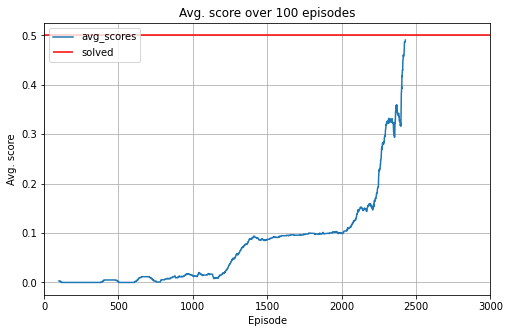

In [14]:
length = 100
avg_scores = moving_average(score_hist, length)
plt.figure(figsize=(8,5))
plt.plot(avg_scores, label='avg_scores')
plt.hlines(.5, xmin=0, xmax=3000, colors='r', label='solved')
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Avg. score')
plt.title(f'Avg. score over {length} episodes')
plt.legend(loc='upper left')
plt.xlim((0, 3000))

## Save My Weights

In [18]:
from datetime import datetime
def save_agent(agents, score_hist, avg_scores=None):
    """Saves the agent's parameters and the underlying pytorch model"""
    checkpoint = {'score_hist': score_hist}
    
    for name, agent in zip(('A', 'B'), agents):
        checkpoint[f'{name}_actor_state_dict'] = agent.actor_local.state_dict()
        checkpoint[f'{name}_critic_state_dict'] = agent.critic_local.state_dict() 
            
    torch.save(checkpoint, 'my_weights.pth')



In [19]:
save_agent(agents, score_hist, avg_scores=avg_scores)

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 